## DATA ENGINEERING & ANALYSIS PROJECT
### RECORD LABEL & ARTIST USING SPOTIFY & BILLBOARD METRICS
#### Suppose a record label is looking to promote an up-and-coming artist. The label has already allocated the proper funding to advertise the artist and her next album toward a solid first week of streams/sales. Eventually, the artist and the label hope to create self-sufficient growth through the quality of the project (and word of mouth of her listeners). However, the artist has 50 demos in her backlog and the label will allocate enough money to mix and master up to 20 of the demos into fully-formed songs. Given the dataset of all Billboard hits and their respective characteristics on Spotify, how could we use data to help the record label and the artist select the right set of songs to maximize her chances of having her songs be a hit on the Billboard?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

### Helper Functions to Be Used in ETL Section

In [2]:
def drop_dups(df, subs):
    # df    REPRESENTS PANDAS DATAFRAME TO BE CHANGED
    # subs  ARG REPRESENTS SINGLE STRING OR LIST OF STRINGS FOR COLUMN NAMES
    #       WHERE DUPLICATES REMAIN
    #
    # GOAL OF THIS HELPER FUNCTION IS TO REMOVE DUPLICATES THAT MAY EXIST IN A
    # ROW IN DATAFRAME. FOR EXAMPLE, WE WON'T NEED TO SEE ONE SONG/ARTIST/ALBUM
    # MULTIPLE TIMES IN THE CHARTS SINCE WE'RE ALSO GIVEN THE AMOUNT OF WEEKS
    # THAT THE ARTIST HAS BEEN ON THE CHARTS.
    df.drop_duplicates(subset=subs, keep='first', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


def extract_artist_ids(df):
    # df    REPRESENTS PANDAS DATAFRAME TO BE CHANGED
    #
    # GOAL OF THIS IS TO EXTRACT ARTIST_ID AND ARTIST_NAME FROM VAGUE 'ARTISTS'
    # COLUMN. COLUMN VALUES ARE IN A STRING FORMAT TO LOOK LIKE A DICTIONARY
    # BUT IT IS NOT BEING RECOGNIZED AS A DICTIONARY BY read_csv
    artist_ids = []
    artist_names = []
    for i in df['artists']:
        splitted = i.split("'")
        artist_ids.append(splitted[1])
        artist_names.append(splitted[3])
    # print(artist_ids)
    # print(artist_names)
    ids = pd.Series(artist_ids)
    names = pd.Series(artist_names)
    df['artist_id'] = ids
    df['artist_name'] = names
    df.drop('artists', axis='columns', inplace=True)
    return df

### Start of ETL Section
#### Extract Data from CSVs

In [3]:
# METADATA

albums_df = pd.read_csv("musicoset_metadata/albums.csv", sep='	')
albums_df = extract_artist_ids(albums_df)
albums_df.rename(columns={'name': 'album_name', 'image_url': 'album_image_url',
                          'popularity': 'album_popularity'}, inplace=True)

artists_df = pd.read_csv("musicoset_metadata/artists.csv", sep='	')
artists_df.rename(
    columns={'name': 'artist_name', 'image_url': 'artist_image_url',
             'popularity': 'artist_popularity'}, inplace=True)

releases_df = pd.read_csv("musicoset_metadata/releases.csv", sep='	')
songs_df = pd.read_csv("musicoset_metadata/songs.csv", sep='	')
songs_df = extract_artist_ids(songs_df)
songs_df.rename(
    columns={'name': 'song_name', 'popularity': 'song_popularity'}, inplace=True)

tracks_df = pd.read_csv("musicoset_metadata/tracks.csv", sep='	')
tracks_df.rename(columns={'song_id': 'track_id'}, inplace=True)

# POPULARITY
album_chart_df = pd.read_csv("musicoset_popularity/album_chart.csv",
                             sep='	')
album_chart_df = drop_dups(album_chart_df, ['album_id'])
album_pop_df = pd.read_csv("musicoset_popularity/album_pop.csv", sep='	')

artist_chart_df = pd.read_csv("musicoset_popularity/artist_chart.csv",
                              sep='	')
artist_chart_df = drop_dups(artist_chart_df, ['artist_id'])
artist_pop_df = pd.read_csv("musicoset_popularity/artist_pop.csv", sep='	')

song_chart_df = pd.read_csv("musicoset_popularity/song_chart.csv", sep='	')
song_chart_df = drop_dups(song_chart_df, ['song_id'])

song_pop_df = pd.read_csv("musicoset_popularity/song_pop.csv", sep='	')

# SONG FEATURES
acoustic_features_df = pd.read_csv(
    "musicoset_songfeatures/acoustic_features.csv", sep='	')
lyrics_df = pd.read_csv("musicoset_songfeatures/lyrics.csv", sep='	')

### THIS IS THE TRANSFER SECTION
#### TO BE COMPLETED AND VISUALIZED ON JUPYTER

In [4]:
# ACOUSTIC FEATURES + SONG CHART + SONG POPULARITY + songs_df
# DATAFRAME OF INTEREST 1
df1 = pd.merge(acoustic_features_df, song_chart_df,
                                    on='song_id')
df1 = pd.merge(df1, song_pop_df, on='song_id')
df1 = pd.merge(df1, songs_df, on='song_id')
df1['week'] = pd.to_datetime(df1['week'], format='%Y-%m-%d')
# df1 = pd.merge(df1, tracks_df, on='song_id')
# songs duplicates if singles should be removed but preserve duplicates if
# released with album

# NEXT WE WANT TO TRACK ALBUM RELEASES + ARTIST POPULARITY
# HOW MUCH DOES ARTIST'S POPULARITY CONTRIBUTE TO ALBUM'S POPULARITY
# (AND VICE VERSA)?
# DATAFRAME OF INTEREST 2
df2 = pd.merge(albums_df, releases_df, on=["album_id", "artist_id"])
df2 = pd.merge(df2, artists_df, on=["artist_id", "artist_name"])
df2 = pd.merge(df2, album_pop_df, on="album_id")
df2 = pd.merge(df2, album_chart_df, on="album_id")
df2 = pd.merge(df2, tracks_df, on=['album_id'])
song_id_col = df2.pop("track_id")
df2.insert(0, "track_id", song_id_col)
df2.drop(['release_date_precision_x', 'release_date_x'],
         axis='columns', inplace=True)
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')
df2.rename(columns={'release_date_y': 'release_date',
                    'release_date_precision_y': 'release_date_precision'},
           inplace=True)

# HOW MUCH DOES ARTIST'S POPULARITY CONTRIBUTE TO SONG'S POPULARITY
# (AND VICE VERSA)?
# DATAFRAME OF INTEREST 3
df3 = pd.merge(artists_df, releases_df, on="artist_id")
df3 = pd.merge(df3, artist_chart_df, on="artist_id")
df3 = pd.merge(df3, artist_pop_df, on="artist_id")
df3 = pd.merge(df3, songs_df, on=["artist_id","artist_name"])
df3 = pd.merge(df3, tracks_df,
               on=["album_id", "release_date", "release_date_precision"])
df3['week'] = pd.to_datetime(df3['week'], format='%Y-%m-%d')

#### WHAT MAKES A SONG POPULAR THROUGH THE DECADES AND WHAT DOES THIS TELL US ABOUT THE ARTIST-LISTENER RELATIONSHIP OF THEIR RESPECTIVE ERAS?
#### DEFINE A HIT: A HIT IS SOMETHING THAT HAS ACCOMPLISHED THE BILLBOARD TOP 30 AND STAYED ON THE BILLBOARD CHARTS FOR AT LEAST
#### 4 WEEKS (ABOVE OR BELOW TOP 30)

In [5]:
# define the hits
df1.columns

Index(['song_id', 'duration_ms', 'key', 'mode', 'time_signature',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'rank_score',
       'peak_position', 'weeks_on_chart', 'week', 'year_end_score', 'is_pop',
       'year', 'song_name', 'billboard', 'song_popularity', 'explicit',
       'song_type', 'artist_id', 'artist_name'],
      dtype='object')

In [6]:
# DEFINE THE SONG HITS
df1_hits = df1.drop(df1[df1['peak_position'] > 30].index, inplace = False)
df1_hits.drop(df1_hits[df1_hits['weeks_on_chart'] < 4].index, inplace = True)
#df1_hits = df1
df1_hits.reset_index(drop=True, inplace=True)
df1_hits # these are the song hits according to my parameters and isolated columns of interest

,song_id,duration_ms,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,...,year_end_score,is_pop,year,song_name,billboard,song_popularity,explicit,song_type,artist_id,artist_name
0,2GHO21NrpLapnnfx5z2UL6,192888,3,0,4,0.03380,0.543,0.868,0.000289,0.190,...,72,False,2018,Girl Like You,"('Girl Like You', 'Jason Aldean')",48,False,Solo,3FfvYsEGaIb52QPXhg4DcH,Jason Aldean
1,5HnXcJJbNXQQ7tRlQ9VN1v,189533,7,1,4,0.16000,0.711,0.696,0.000000,0.170,...,130,False,2018,Good Girl,"('Good Girl', 'Dustin Lynch')",71,False,Solo,1dID9zgn0OV0Y8ud7Mh2tS,Dustin Lynch
2,01jIO8SJFnpSiNLH1JaBZ5,217387,8,0,4,0.41300,0.735,0.453,0.000000,0.104,...,75,False,2018,You,"('You', 'Jacquees')",70,True,Solo,4tMm1dU6Gn04VAZ9ClHcIZ,Jacquees
3,6viHvc13l9A6Ua6xugpeX6,228480,4,1,4,0.00204,0.487,0.859,0.000000,0.322,...,79,False,2018,Last Shot,"('Last Shot', 'Kip Moore')",65,False,Solo,2hJPr4lk7Q8SSvCVBl9fWM,Kip Moore
4,7zLYKWcXnYeHHWidalz7rj,165000,11,1,4,0.46200,0.699,0.558,0.000000,0.116,...,235,False,2018,Noticed,"('Noticed', 'Lil Mosey')",80,True,Solo,5zctI4wO9XSKS8XwcnqEHk,Lil Mosey
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,506XJjrY7nEaOkvhgks5ho,229637,4,0,4,0.00332,0.522,0.711,0.000000,0.168,...,89,False,1983,Carrie's Gone,"(""Carrie's Gone"", 'Le Roux')",6,False,Solo,4m5AiTlgcHYAeFnLWEIZeG,LeRoux
2992,4zYo6RXvGfeKOgN4NH3ZHf,193985,9,1,4,0.00586,0.632,0.817,0.000898,0.127,...,122,False,1982,The Last Safe Place On Earth,"('The Last Safe Place On Earth', 'Le Roux')",1,False,Solo,4m5AiTlgcHYAeFnLWEIZeG,LeRoux
2993,2L3uJj4ha9Y5QCZUkld5ah,92667,2,1,4,0.09140,0.480,0.868,0.000008,0.331,...,166,False,1975,Like They Say In L.A.,"('Like They Say In L.A.', 'East L.A. Car Pool')",0,False,Solo,47fxSsneKsa21U6GhzdQjj,L.A. Carpool
2994,7uF5AOQd5EoZMySWcq2M5H,189187,7,1,4,0.52200,0.291,0.412,0.000000,0.463,...,42,False,1968,Send My Baby Back,"('Send My Baby Back', 'Freddie Hughes')",2,False,Solo,6pNfWWILVcCkm6c0bbovMD,Fred Hughes


### SONGS CHANGE WITH THE TIMES
#### Create a category column called "Decade"
#### 1960 corresponds to the 60s, 1970 to 70s, and so on.

In [7]:
decades = []
for _, row in df1_hits.iterrows():
    curr_year = row['year']
    if curr_year >= 2011 and curr_year <= 2020:
        decades.append(2010)
    elif curr_year >= 2001 and curr_year <= 2010:
        decades.append(2000)
    elif curr_year >= 1991 and curr_year <= 2000:
        decades.append(1990)
    elif curr_year >= 1981 and curr_year <= 1990:
        decades.append(1980)
    elif curr_year >= 1971 and curr_year <= 1980:
        decades.append(1970)
    else:
        decades.append(1960)

df1_hits['Decade'] = decades

### START ANALYZING SONG FEATURES OVER EACH DECADE
#### Used boxplots since they plot the summary statistics and give a more holistic view of the decade. Outliers/fliers were removed and the mean was overlaid instead. Since mean averages are affected by outliers, the relationship between the median line and the mean data point will show how outliers are affecting the data.

In [8]:
df1_hits.columns

Index(['song_id', 'duration_ms', 'key', 'mode', 'time_signature',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'rank_score',
       'peak_position', 'weeks_on_chart', 'week', 'year_end_score', 'is_pop',
       'year', 'song_name', 'billboard', 'song_popularity', 'explicit',
       'song_type', 'artist_id', 'artist_name', 'Decade'],
      dtype='object')

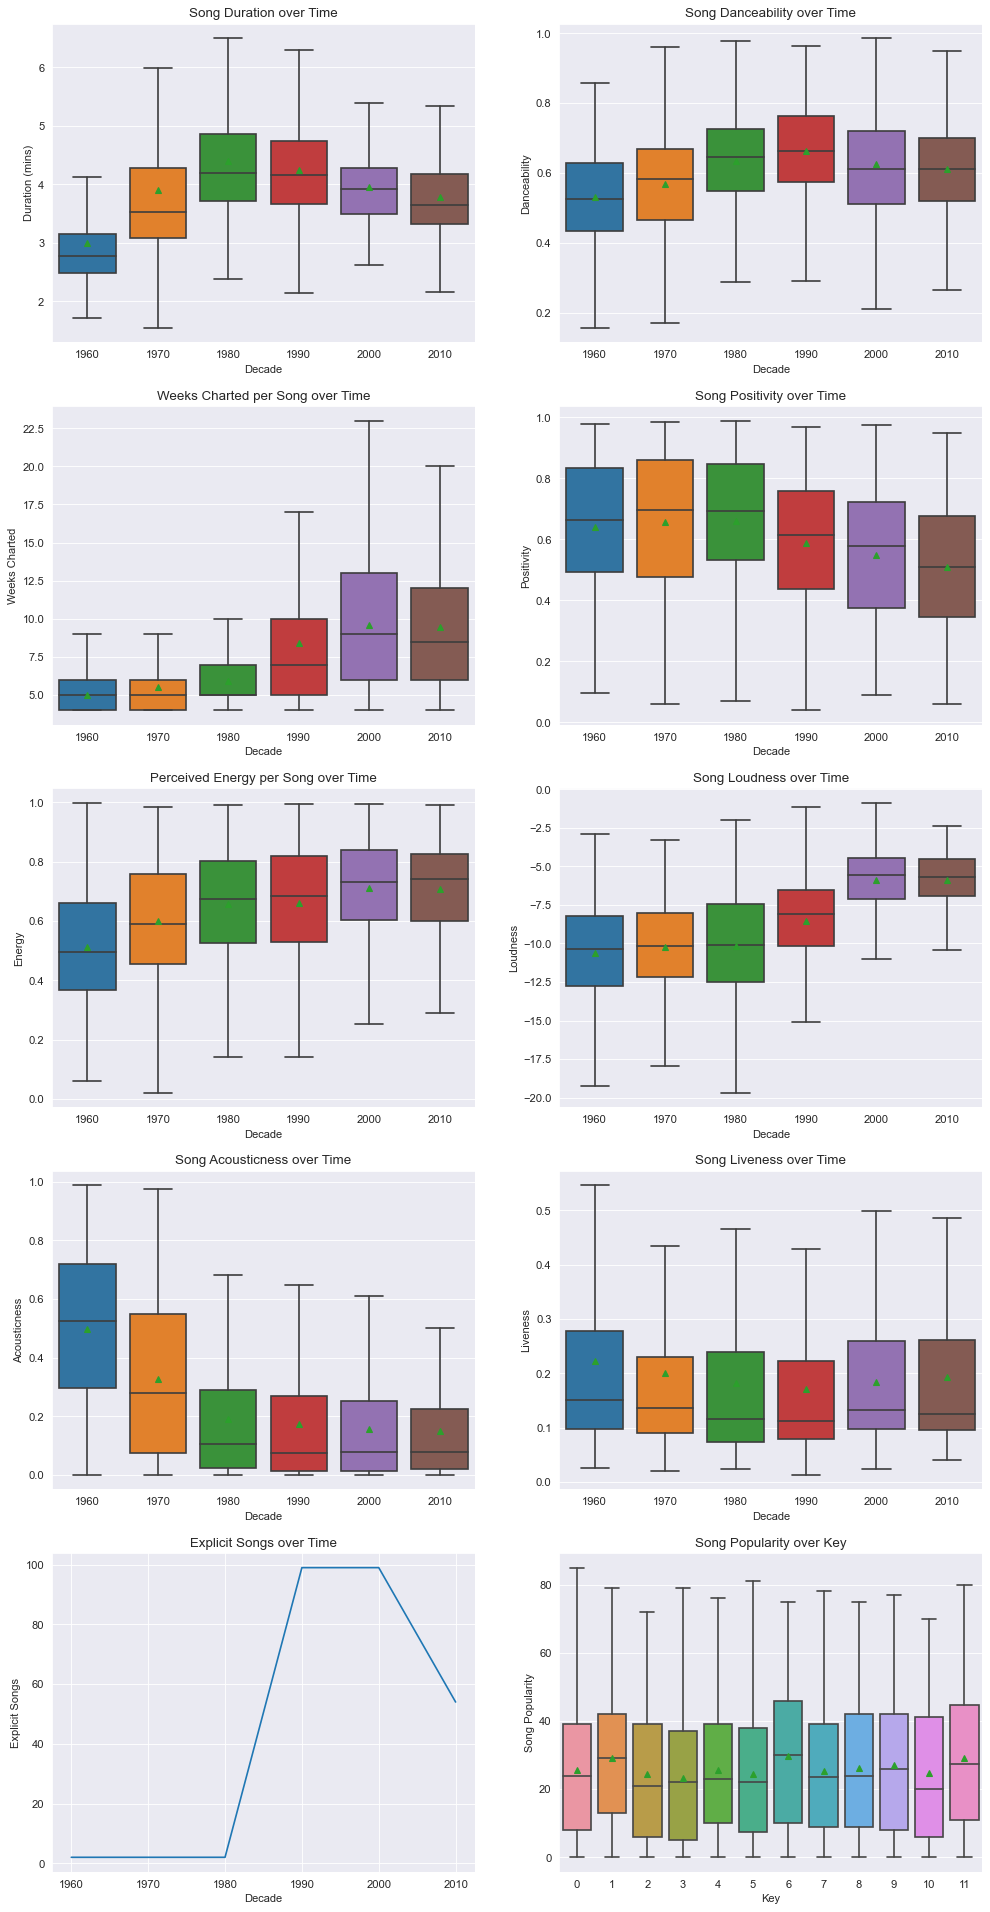

In [9]:
df1_hits['duration_min'] = np.array(df1_hits['duration_ms'] / 60000)

sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(15, 30), dpi=80)
axes[0, 0].set_title('Song Duration over Time')
sns.boxplot(data=df1_hits, x="Decade", y="duration_min", ax=axes[0,0], showmeans=True, showfliers = False)
#sns.stripplot(data=df1_hits, x="Decade", y="duration_min", ax=axes[0,0])
axes[0, 0].set(xlabel='Decade', ylabel='Duration (mins)')

axes[0, 1].set_title('Song Danceability over Time')
sns.boxplot(data=df1_hits, x="Decade", y="danceability", ax=axes[0,1], showmeans=True, showfliers = False)
axes[0, 1].set(xlabel='Decade', ylabel='Danceability')

axes[1, 0].set_title('Weeks Charted per Song over Time')
sns.boxplot(data=df1_hits, x="Decade", y="weeks_on_chart", ax=axes[1,0], showmeans=True, showfliers = False)
axes[1, 0].set(xlabel='Decade', ylabel='Weeks Charted')

axes[1, 1].set_title('Song Positivity over Time')
sns.boxplot(data=df1_hits, x="Decade", y="valence", ax=axes[1,1], showmeans=True, showfliers = False)
axes[1, 1].set(xlabel='Decade', ylabel='Positivity')

axes[2, 0].set_title('Perceived Energy per Song over Time')
sns.boxplot(data=df1_hits, x="Decade", y="energy", ax=axes[2,0], showmeans=True, showfliers = False)
axes[2, 0].set(xlabel='Decade', ylabel='Energy')

axes[2, 1].set_title('Song Loudness over Time')
sns.boxplot(data=df1_hits, x="Decade", y="loudness", ax=axes[2,1], showmeans=True, showfliers = False)
axes[2, 1].set(xlabel='Decade', ylabel='Loudness')

axes[3, 0].set_title('Song Acousticness over Time')
sns.boxplot(data=df1_hits, x="Decade", y="acousticness", ax=axes[3,0], showmeans=True, showfliers = False)
axes[3, 0].set(xlabel='Decade', ylabel='Acousticness')

axes[3, 1].set_title('Song Liveness over Time')
sns.boxplot(data=df1_hits, x="Decade", y="liveness", ax=axes[3,1], showmeans=True, showfliers = False)
axes[3, 1].set(xlabel='Decade', ylabel='Liveness')

axes[4, 0].set_title('Explicit Songs over Time')
sns.lineplot(data=df1_hits.groupby(['Decade']).sum(numeric_only=True).reset_index(), x="Decade", y="explicit", ax=axes[4,0])
axes[4, 0].set(xlabel='Decade', ylabel='Explicit Songs')

axes[4, 1].set_title('Song Popularity over Key')
sns.boxplot(data=df1_hits, x="key", y="song_popularity", ax=axes[4,1], showmeans=True, showfliers = True)
axes[4, 1].set(xlabel='Key', ylabel='Song Popularity')

print()

### Table of Stats

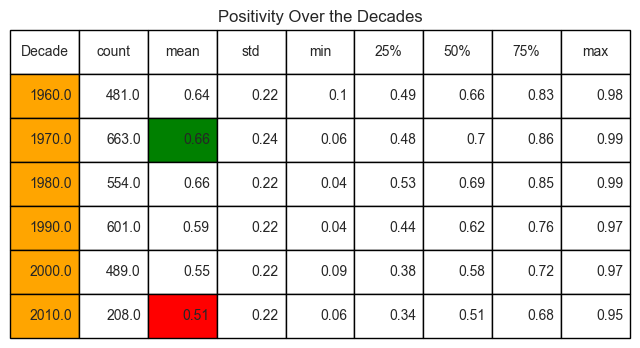

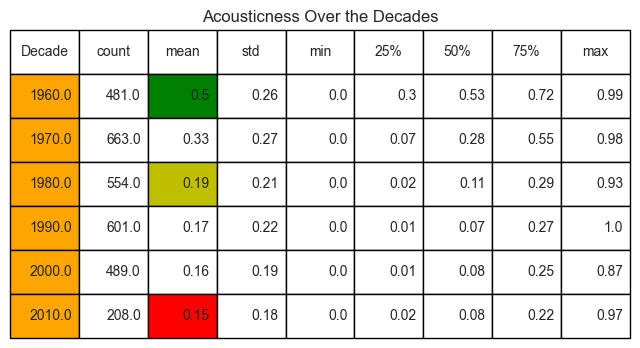

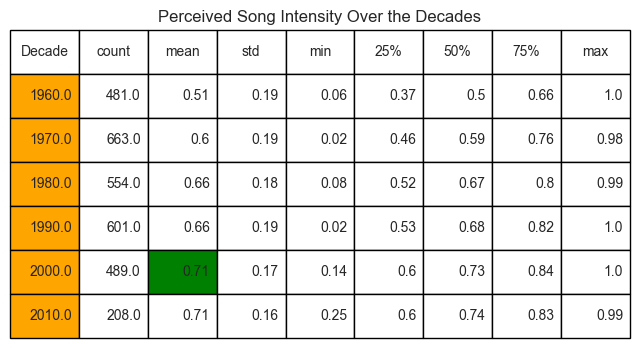

In [10]:
# fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(20, 30), dpi=80)

dfxx = df1_hits.groupby(['Decade']).describe().round(2).reset_index()
dfxx_new = dfxx['valence'].copy()
dfxx_new.insert(0, column='Decade', value= dfxx['Decade'])
#dfxx_new.set_index('Decade',drop=True, append=False, inplace=True, verify_integrity=False)

fig = plt.figure(figsize=(8, 4))
bbox=[0, 0, 1, 1]
plt.axis('off')
colors = [["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","g","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","r","w","w","w","w","w","w"]]
plt.table(cellText = dfxx_new.values, bbox=bbox, colLabels = dfxx_new.columns, cellColours=colors)
plt.title("Positivity Over the Decades")


dfxx = df1_hits.groupby(['Decade']).describe().round(2).reset_index()
dfxx_new = dfxx['acousticness'].copy()
dfxx_new.insert(0, column='Decade', value= dfxx['Decade'])
#dfxx_new.set_index('Decade',drop=True, append=False, inplace=True, verify_integrity=False)

fig = plt.figure(figsize=(8, 4))
bbox=[0, 0, 1, 1]
plt.axis('off')
colors = [["orange","w","g","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","y","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","r","w","w","w","w","w","w"]]
plt.table(cellText = dfxx_new.values, bbox=bbox, colLabels = dfxx_new.columns, cellColours=colors)
plt.title("Acousticness Over the Decades")

dfxx = df1_hits.groupby(['Decade']).describe().round(2).reset_index()
dfxx_new = dfxx['energy'].copy()
dfxx_new.insert(0, column='Decade', value= dfxx['Decade'])
#dfxx_new.set_index('Decade',drop=True, append=False, inplace=True, verify_integrity=False)

fig = plt.figure(figsize=(8, 4))
bbox=[0, 0, 1, 1]
plt.axis('off')
colors = [["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"],
          ["orange","w","g","w","w","w","w","w","w"],
          ["orange","w","w","w","w","w","w","w","w"]]
plt.table(cellText = dfxx_new.values, bbox=bbox, colLabels = dfxx_new.columns, cellColours=colors)
plt.title("Perceived Song Intensity Over the Decades")

print()

### Artist Dataframe Analysis

In [11]:
# DEFINE THE ALBUM HITS
df2_hits = df2.drop(df2[df2['week_count'] > 30].index, inplace = False)
# df2_hits.drop(df2_hits[df2_hits['week_count'] < 4].index, inplace = True)
df2_hits.reset_index(drop=True, inplace=True)
#df2_hits = df2_hits[['album_popularity', 'total_tracks', 'album_type', 'artist_id',
#                     'followers', 'artist_popularity', 'artist_type',
#                     'main_genre','year_end_score', 'is_pop',
#                     'year', 'rank_score', 'peak_position', 'week_count', 'date',
#                     'track_number', 'release_date']].copy()

In [12]:
decades = []
for _, row in df2_hits.iterrows():
    curr_year = row['year']
    if curr_year >= 2011 and curr_year <= 2020:
        decades.append(2010)
    elif curr_year >= 2001 and curr_year <= 2010:
        decades.append(2000)
    elif curr_year >= 1991 and curr_year <= 2000:
        decades.append(1990)
    elif curr_year >= 1981 and curr_year <= 1990:
        decades.append(1980)
    elif curr_year >= 1971 and curr_year <= 1980:
        decades.append(1970)
    else:
        decades.append(1960)

df2_hits['Decade'] = decades

In [13]:
col_to_move = df2_hits.pop('album_id')
df2_hits.insert(0, "album_id", col_to_move)

In [14]:
df2_hits_grouped = df2_hits.groupby(['album_id', 'album_name', 'artist_id',
       'artist_name', 'billboard', 'total_tracks', 'album_type','artist_type',
       'main_genre','release_date', 'release_date_precision', 'Decade']).mean(numeric_only=False).reset_index()

/var/folders/j5/l8t1kjzn1mx8p6qgkp_mvjs40000gn/T/ipykernel_77201/4101091321.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df2_hits_grouped = df2_hits.groupby(['album_id', 'album_name', 'artist_id',


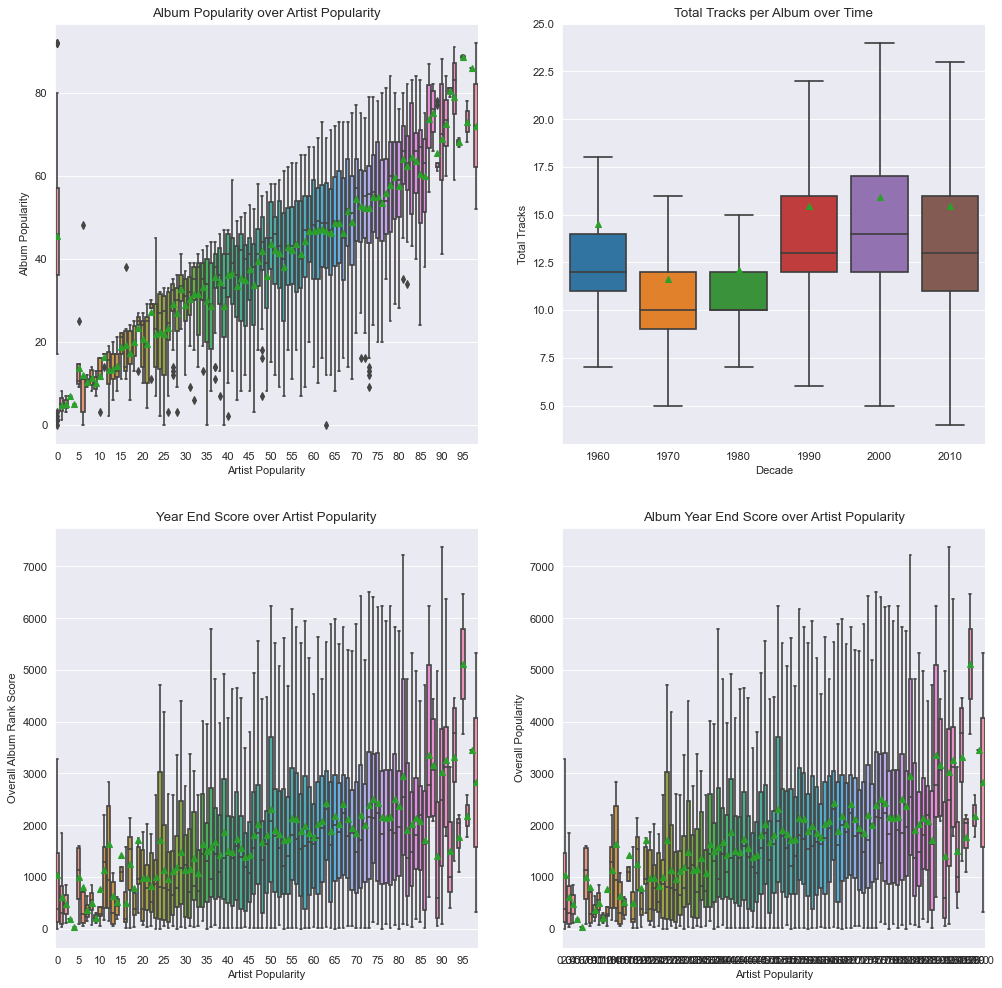

In [15]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15, 15), dpi=80)
axes[0, 0].set_title('Album Popularity over Artist Popularity')
sns.boxplot(data=df2_hits_grouped, x="artist_popularity", y="album_popularity", ax=axes[0,0], showmeans=True, showfliers = True)
axes[0, 0].set(xlabel='Artist Popularity', ylabel='Album Popularity')
axes[0, 0].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[0, 0].xaxis.set_major_formatter(ticker.ScalarFormatter())

axes[0, 1].set_title('Total Tracks per Album over Time')
sns.boxplot(data=df2_hits_grouped, x="Decade", y="total_tracks", ax=axes[0,1], showmeans=True, showfliers = False)
axes[0, 1].set(xlabel='Decade', ylabel='Total Tracks')

axes[1, 0].set_title('Year End Score over Artist Popularity')
sns.boxplot(data=df2_hits_grouped, x="artist_popularity", y="year_end_score", ax=axes[1,0], showmeans=True, showfliers = False)
axes[1, 0].set(xlabel='Artist Popularity', ylabel='Overall Album Rank Score')
axes[1, 0].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[1, 0].xaxis.set_major_formatter(ticker.ScalarFormatter())

axes[1, 1].set_title('Album Year End Score over Artist Popularity')
sns.boxplot(data=df2_hits_grouped, x="artist_popularity", y="year_end_score", ax=axes[1,1], showmeans=True, showfliers = False)
axes[1, 1].set(xlabel='Artist Popularity', ylabel='Overall Popularity')

print()

In [16]:
df3

,artist_id,artist_name,followers,artist_popularity,artist_type,main_genre,genres,artist_image_url,album_id,release_date,...,is_pop,year,song_id,song_name,billboard,song_popularity,explicit,song_type,track_id,track_number
0,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,34554242,96,singer,dance pop,"['dance pop', 'pop', 'post-teen pop']",https://i.scdn.co/image/b1dfbe843b0b9f54ab2e58...,3tx8gQqWbGwqIGZHqDNrGe,2018-08-17,...,True,2018,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",86,True,Solo,4OafepJy2teCjYJbvFE60J,9
1,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,34554242,96,singer,dance pop,"['dance pop', 'pop', 'post-teen pop']",https://i.scdn.co/image/b1dfbe843b0b9f54ab2e58...,3tx8gQqWbGwqIGZHqDNrGe,2018-08-17,...,True,2018,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",86,True,Solo,5OCJzvD7sykQEKHH7qAC3C,5
2,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,34554242,96,singer,dance pop,"['dance pop', 'pop', 'post-teen pop']",https://i.scdn.co/image/b1dfbe843b0b9f54ab2e58...,3tx8gQqWbGwqIGZHqDNrGe,2018-08-17,...,True,2018,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",86,True,Solo,2qT1uLXPVPzGgFOx4jtEuo,10
3,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,34554242,96,singer,dance pop,"['dance pop', 'pop', 'post-teen pop']",https://i.scdn.co/image/b1dfbe843b0b9f54ab2e58...,3tx8gQqWbGwqIGZHqDNrGe,2018-08-17,...,True,2018,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",86,True,Solo,70khXICDeTTxgYtw3EysKH,6
4,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,34554242,96,singer,dance pop,"['dance pop', 'pop', 'post-teen pop']",https://i.scdn.co/image/b1dfbe843b0b9f54ab2e58...,3tx8gQqWbGwqIGZHqDNrGe,2018-08-17,...,True,2018,3e9HZxeyfWwjeyPAMmWSSQ,"thank u, next","('Thank U, Next', 'Ariana Grande')",86,True,Solo,0WdR2AyLW1Drd3OUdwezM0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3062951,2JqijdV9jIJWxfgZJ5ZsEk,Lo-Key?,22,9,band,-,[],https://i.scdn.co/image/7f5aa9793773a487270166...,4WzO6i4CTbY2J9e7ltJImX,1992-10-06,...,False,1992,44tMr9ypzWXXFq0wjDqphF,I Got A Thang 4 Ya!,"('I Got A Thang 4 Ya!', 'Lo-Key?')",6,False,Solo,48z9CEN9Cgdy1w22i8kbnH,11
3062952,2JqijdV9jIJWxfgZJ5ZsEk,Lo-Key?,22,9,band,-,[],https://i.scdn.co/image/7f5aa9793773a487270166...,4WzO6i4CTbY2J9e7ltJImX,1992-10-06,...,False,1992,44tMr9ypzWXXFq0wjDqphF,I Got A Thang 4 Ya!,"('I Got A Thang 4 Ya!', 'Lo-Key?')",6,False,Solo,44tMr9ypzWXXFq0wjDqphF,14
3062953,4WCakp6x5s025ASunyFBE5,Soho,33,23,-,-,[],https://i.scdn.co/image/6ca343f5316336f8833651...,4uD7J9637aueCRXrAOnduG,1991,...,False,1991,6KnNSH6Os9TgxmOeRuSsme,Hippychick,"('Hippychick', 'Soho')",31,False,Solo,6KnNSH6Os9TgxmOeRuSsme,2
3062954,4WCakp6x5s025ASunyFBE5,Soho,33,23,-,-,[],https://i.scdn.co/image/6ca343f5316336f8833651...,4uD7J9637aueCRXrAOnduG,1991,...,True,1990,6KnNSH6Os9TgxmOeRuSsme,Hippychick,"('Hippychick', 'Soho')",31,False,Solo,6KnNSH6Os9TgxmOeRuSsme,2


In [17]:
df3.columns

Index(['artist_id', 'artist_name', 'followers', 'artist_popularity',
       'artist_type', 'main_genre', 'genres', 'artist_image_url', 'album_id',
       'release_date', 'release_date_precision', 'rank_score', 'peak_position',
       'weeks_on_chart', 'week', 'year_end_score', 'is_pop', 'year', 'song_id',
       'song_name', 'billboard', 'song_popularity', 'explicit', 'song_type',
       'track_id', 'track_number'],
      dtype='object')

In [18]:
df1_hits.columns

Index(['song_id', 'duration_ms', 'key', 'mode', 'time_signature',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'valence', 'tempo', 'rank_score',
       'peak_position', 'weeks_on_chart', 'week', 'year_end_score', 'is_pop',
       'year', 'song_name', 'billboard', 'song_popularity', 'explicit',
       'song_type', 'artist_id', 'artist_name', 'Decade', 'duration_min'],
      dtype='object')

### Attempt at K-means Clustering Data from df1_hits

In [71]:
features = ['time_norm','acousticness', 'energy', 'loudness','instrumentalness', 'liveness','speechiness','duration_min','valence','weeks_on_chart','explicit']

In [72]:
df1_hits_km = df1_hits.copy()

#### Normalize each column from 0 to 1 to allow for precise, accurate clustering

In [73]:
df1_hits_km['time_scale'] = pd.to_datetime(df1_hits_km['week']).astype('int64')
max_a = df1_hits_km.time_scale.max()
min_a = df1_hits_km.time_scale.min()
min_norm = 0
max_norm =1
df1_hits_km['time_norm'] = (df1_hits_km.time_scale- min_a) *(max_norm - min_norm) / (max_a-min_a) + min_norm

In [74]:
scaler = MinMaxScaler()
for i in range(1,8):
    scaler.fit(df1_hits_km[[features[i]]])
    df1_hits_km[features[i]] = scaler.transform(df1_hits_km[[features[i]]])

In [75]:
df1_hits_km[features].head()

,time_norm,acousticness,energy,loudness,instrumentalness,liveness,speechiness,duration_min,valence,weeks_on_chart,explicit
0,1.000000,0.033967,0.866776,0.854927,0.000293,0.181352,0.020947,0.143837,0.433,4,False
1,1.000000,0.160801,0.690510,0.841204,0.000000,0.160861,0.104254,0.140589,0.694,6,False
2,1.000000,0.415073,0.441484,0.718696,0.000000,0.093238,0.060909,0.167558,0.335,4,True
3,1.000000,0.002047,0.857553,0.865866,0.000000,0.316598,0.042539,0.178299,0.377,5,False
4,0.998954,0.464320,0.549088,0.743168,0.000000,0.105533,0.061070,0.116835,0.493,10,True


#### Find appropriate number of clusters to use

In [95]:
sse = []
k_rng = range(1,50)
for k in k_rng:
    km = KMeans(n_clusters=k, n_init='auto')
    km.fit(df1_hits_km[features])
    sse.append(km.inertia_)

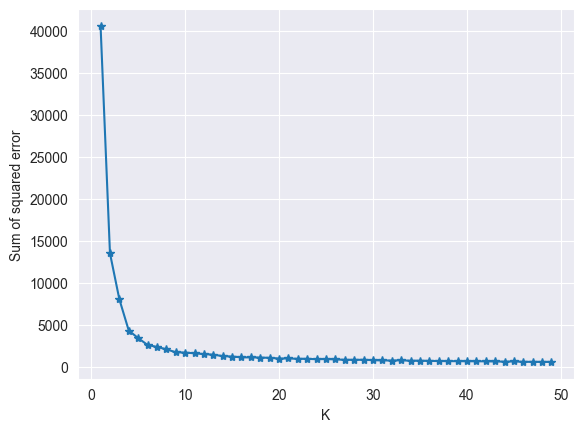

In [96]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse, marker='*')

#### Use K=17. This is the elbow point according to the plot above. You don't want to use a K value that's too high, since you may run the risk of over-fitting the past data. It may lead to a non-causal variable becoming a very influential factor in the model.

In [97]:
# reference this: https://github.com/codebasics/py/blob/master/ML/13_kmeans/13_kmeans_tutorial.ipynb

In [98]:
km = KMeans(n_clusters=17,n_init='auto')
predicted = km.fit_predict(df1_hits_km[features])

In [99]:
df1_hits_km['cluster']=predicted
df1_hits_km

,song_id,duration_ms,key,mode,time_signature,acousticness,danceability,energy,instrumentalness,liveness,...,song_popularity,explicit,song_type,artist_id,artist_name,Decade,duration_min,time_scale,time_norm,cluster
0,2GHO21NrpLapnnfx5z2UL6,192888,3,0,4,0.033967,0.543,0.866776,0.000293,0.181352,...,48,False,Solo,3FfvYsEGaIb52QPXhg4DcH,Jason Aldean,2010,0.143837,1546041600000000000,1.000000,16
1,5HnXcJJbNXQQ7tRlQ9VN1v,189533,7,1,4,0.160801,0.711,0.690510,0.000000,0.160861,...,71,False,Solo,1dID9zgn0OV0Y8ud7Mh2tS,Dustin Lynch,2010,0.140589,1546041600000000000,1.000000,0
2,01jIO8SJFnpSiNLH1JaBZ5,217387,8,0,4,0.415073,0.735,0.441484,0.000000,0.093238,...,70,True,Solo,4tMm1dU6Gn04VAZ9ClHcIZ,Jacquees,2010,0.167558,1546041600000000000,1.000000,16
3,6viHvc13l9A6Ua6xugpeX6,228480,4,1,4,0.002047,0.487,0.857553,0.000000,0.316598,...,65,False,Solo,2hJPr4lk7Q8SSvCVBl9fWM,Kip Moore,2010,0.178299,1546041600000000000,1.000000,14
4,7zLYKWcXnYeHHWidalz7rj,165000,11,1,4,0.464320,0.699,0.549088,0.000000,0.105533,...,80,True,Solo,5zctI4wO9XSKS8XwcnqEHk,Lil Mosey,2010,0.116835,1544227200000000000,0.998954,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,506XJjrY7nEaOkvhgks5ho,229637,4,0,4,0.003333,0.522,0.705882,0.000000,0.158811,...,6,False,Solo,4m5AiTlgcHYAeFnLWEIZeG,LeRoux,1980,0.179419,418694400000000000,0.350296,16
2992,4zYo6RXvGfeKOgN4NH3ZHf,193985,9,1,4,0.005886,0.632,0.814511,0.000912,0.116803,...,1,False,Solo,4m5AiTlgcHYAeFnLWEIZeG,LeRoux,1980,0.144899,393897600000000000,0.336006,14
2993,2L3uJj4ha9Y5QCZUkld5ah,92667,2,1,4,0.091856,0.480,0.866776,0.000008,0.325820,...,0,False,Solo,47fxSsneKsa21U6GhzdQjj,L.A. Carpool,1970,0.046799,179193600000000000,0.212269,0
2994,7uF5AOQd5EoZMySWcq2M5H,189187,7,1,4,0.524622,0.291,0.399467,0.000000,0.461066,...,2,False,Solo,6pNfWWILVcCkm6c0bbovMD,Fred Hughes,1960,0.140254,-43977600000000000,0.083653,0


In [100]:
df1km_0 = df1_hits_km[df1_hits_km.cluster==0]
df1km_1 = df1_hits_km[df1_hits_km.cluster==1]
df1km_2 = df1_hits_km[df1_hits_km.cluster==2]
df1km_3 = df1_hits_km[df1_hits_km.cluster==3]
df1km_4 = df1_hits_km[df1_hits_km.cluster==4]
df1km_5 = df1_hits_km[df1_hits_km.cluster==5]
df1km_6 = df1_hits_km[df1_hits_km.cluster==6]
df1km_7 = df1_hits_km[df1_hits_km.cluster==7]
df1km_8 = df1_hits_km[df1_hits_km.cluster==8]
df1km_9 = df1_hits_km[df1_hits_km.cluster==9]
df1km_10 = df1_hits_km[df1_hits_km.cluster==10]
df1km_11 = df1_hits_km[df1_hits_km.cluster==11]
df1km_12 = df1_hits_km[df1_hits_km.cluster==12]
df1km_13 = df1_hits_km[df1_hits_km.cluster==13]
df1km_14 = df1_hits_km[df1_hits_km.cluster==14]
df1km_15 = df1_hits_km[df1_hits_km.cluster==15]
df1km_16 = df1_hits_km[df1_hits_km.cluster==16]
df1km_list = [df1km_0,df1km_1,df1km_2,df1km_3,
              df1km_4,df1km_5,df1km_6,df1km_7,
              df1km_8,df1km_9,df1km_10,df1km_11,
              df1km_12,df1km_13,df1km_14,df1km_15,df1km_16]

#### Below is all of the data normalized into K=17 clusters. Centroids are represented with white stars

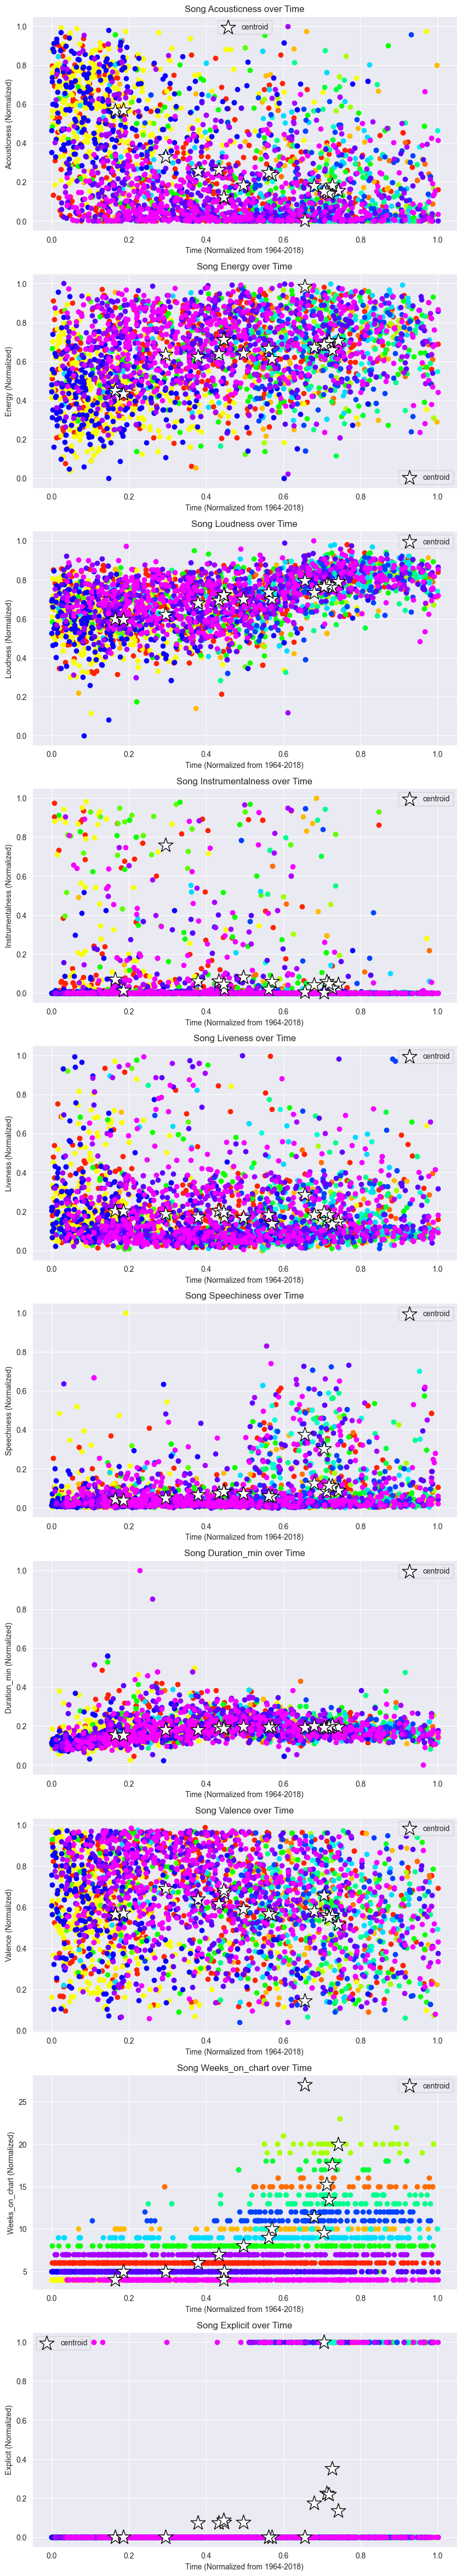

In [101]:
sns.set_style("darkgrid")
cm = plt.get_cmap('gist_rainbow')
fig, axes = plt.subplots(nrows=10, ncols=1,figsize=(10, 60), dpi=100)
time_label = 'Time (Normalized from 1964-2018)'
i = 0
j = 2
for j in range(1,len(features)):
    for i in range(17):
        axes[j-1].set_title('Song ' + features[j].capitalize() + ' over Time')
        axes[j-1].scatter(df1km_list[i].time_norm,df1km_list[i][features[j]], color=cm(1.*(i+1)/18))
        y_label = features[j].capitalize() + ' (Normalized)'
    axes[j-1].scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,j],marker='*',label='centroid', s = 400, edgecolor='black', facecolor='white')
    axes[j-1].set(xlabel=time_label, ylabel=y_label)
    axes[j-1].legend()

#### Let's isolate the centroids

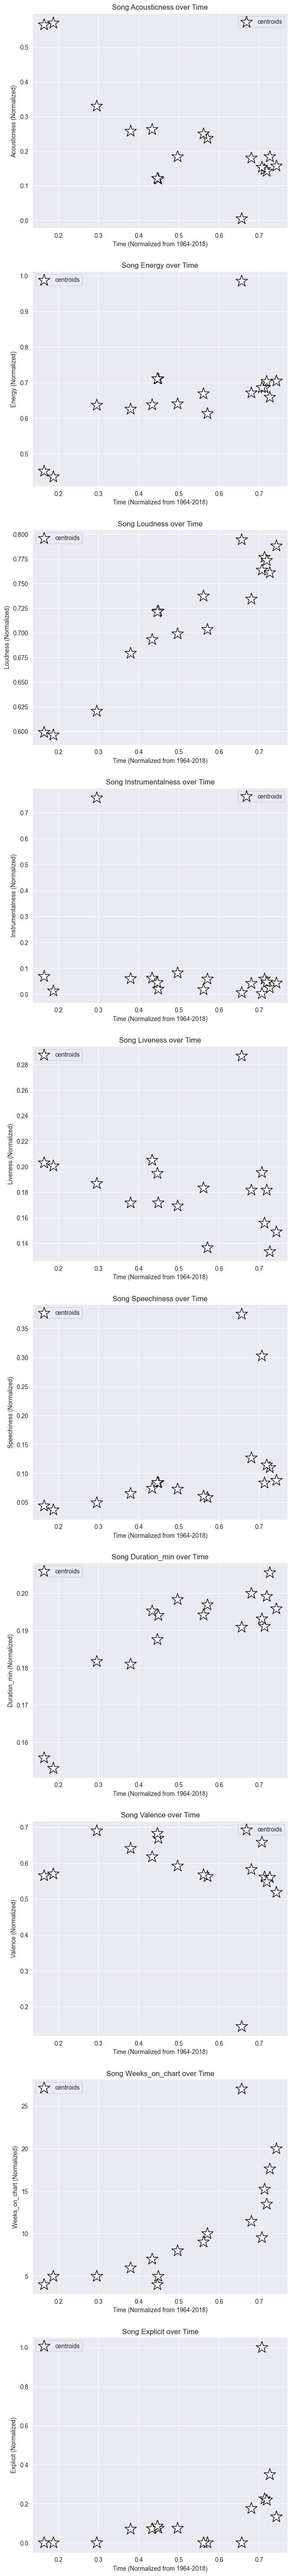

In [119]:
sns.set_style("darkgrid")
cm = plt.get_cmap('gist_rainbow')
fig, axes = plt.subplots(nrows=10, ncols=1,figsize=(7.5, 75), dpi=100)
time_label = 'Time (Normalized from 1964-2018)'
i = 0
j = 2
for j in range(1,len(features)):
    axes[j-1].set_title('Song ' + features[j].capitalize() + ' over Time')
    y_label = features[j].capitalize() + ' (Normalized)'
    axes[j-1].scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,j],marker='*',label='centroids', s = 400, edgecolor='black', facecolor='white')
    axes[j-1].set(xlabel=time_label, ylabel=y_label)
    axes[j-1].legend()

#### Now let's do a side-by-side comparison each plot of song characteristics with the respective boxplot. What's the difference between each?

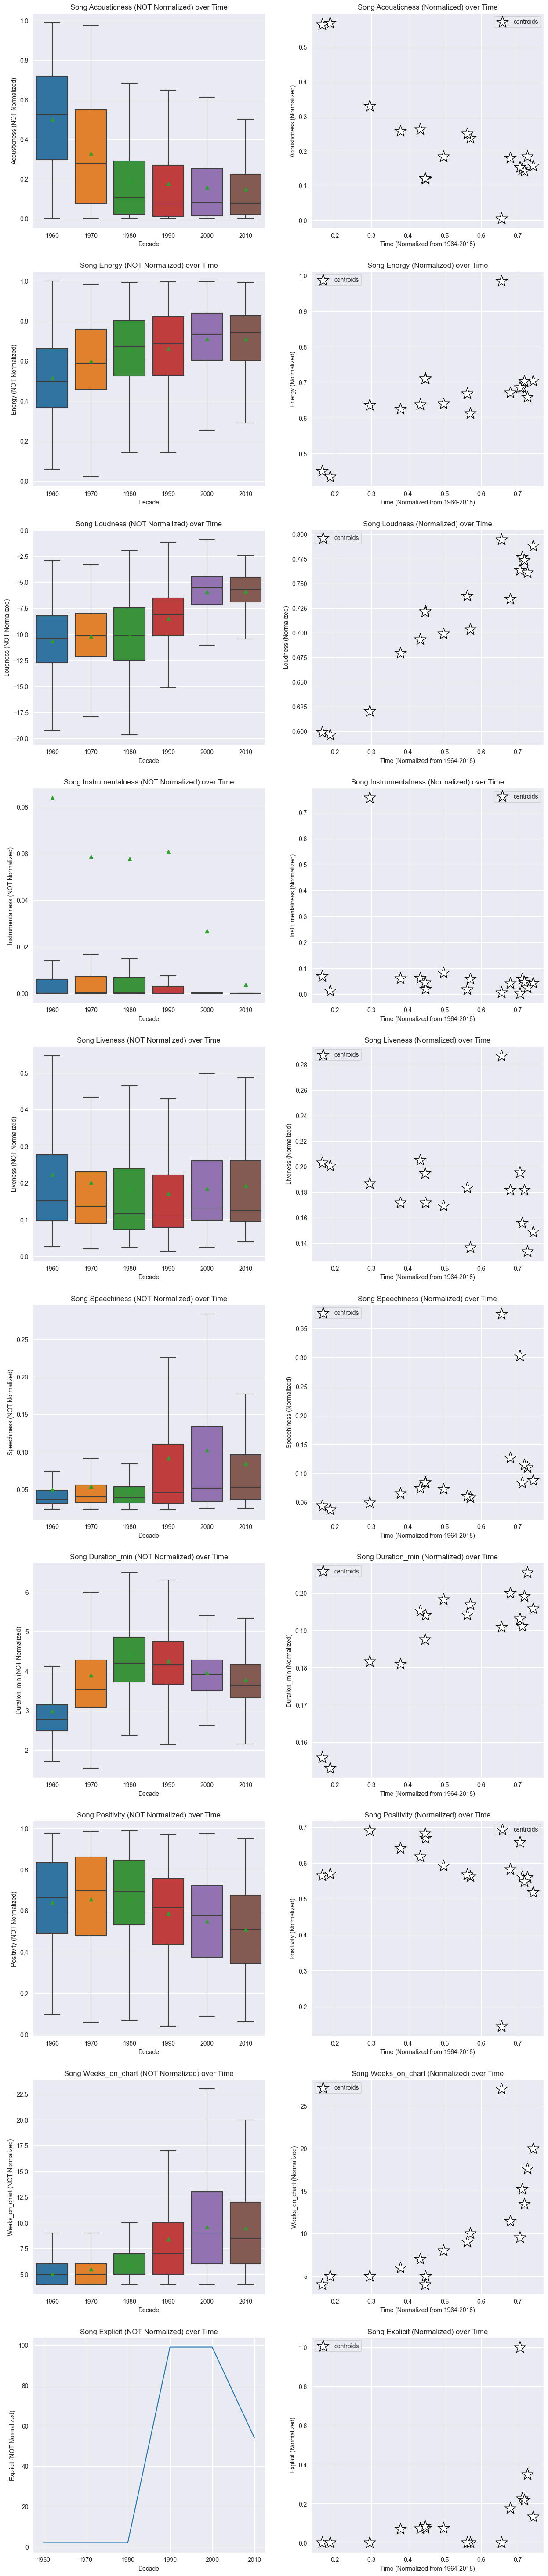

In [149]:
sns.set_style("darkgrid")
cm = plt.get_cmap('gist_rainbow')
fig, axes = plt.subplots(nrows=10, ncols=2,figsize=(15, 75), dpi=100)
time_label_2 = 'Decade'
i = 0
j = 2
for j in range(1,len(features)):
    #boxplots
    jsub = j-1
    if features[j] == 'valence':
        
        y_label = 'Positivity (Normalized)'
        y_label2 = 'Positivity (NOT Normalized)'
    else:
        y_label = features[j].capitalize() + ' (Normalized)'
        y_label2 = features[j].capitalize() + ' (NOT Normalized)'
    axes[jsub, 0].set_title('Song ' + y_label2 + ' over Time')
    
    if j == 10:
        sns.lineplot(data=df1_hits.groupby(['Decade']).sum(numeric_only=True).reset_index(), x="Decade", y="explicit", ax=axes[jsub,0])
    else:
        sns.boxplot(data=df1_hits, x="Decade", y=features[j], ax=axes[jsub,0], showmeans=True, showfliers = False)
    #sns.stripplot(data=df1_hits, x="Decade", y="duration_min", ax=axes[0,0])
    axes[jsub, 0].set(xlabel='Decade', ylabel=y_label2)
    
    # centroids
    axes[jsub, 1].set_title('Song ' + y_label + ' over Time')


    axes[jsub,1].scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,j],marker='*',label='centroids', s = 400, edgecolor='black', facecolor='white')
    axes[jsub,1].set(xlabel=time_label, ylabel=y_label)
    axes[jsub,1].legend()
# plt.savefig('Boxplot_vs_Kmeans.pdf')